In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.transforms.functional import affine
from torch import tensor
import random
import numpy as np
import sys
from IPython.display import clear_output
%matplotlib inline

from network import Linear, NLLLoss, NeuralNetwork
from activations import ELU

from augmentations import apply_augmentations

/home/lnoskov16/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

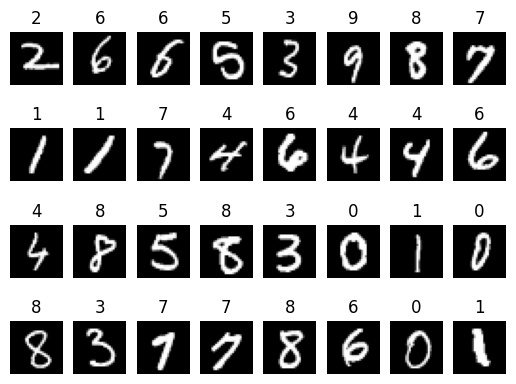

In [4]:
def draw(data, targets):
    for i in range(len(data)):
        plt.subplot(4, 8, i+1)
        plt.imshow(data[i].reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.title(targets[i])
        plt.axis('off')

draw(X, y)

Посмотрим, как действует каждая из аугментаций. Вращение:

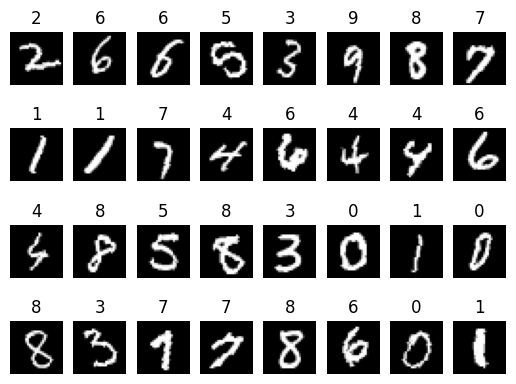

In [5]:
rotated_X = apply_augmentations(X, ['rotate'])
draw(rotated_X, y)

Смещение:

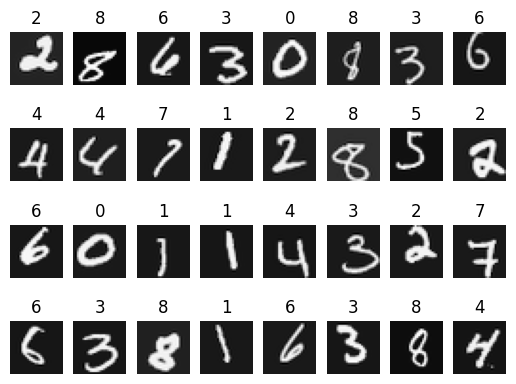

In [6]:
shifted_X = apply_augmentations(X, ['shift'])
draw(shifted_X, y)

Шумы:

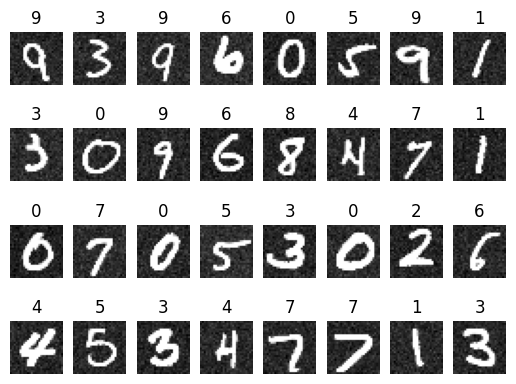

In [7]:
noised_X = apply_augmentations(X, ['noise'])
draw(noised_X, y)

In [14]:
from torchvision.transforms.functional import affine
from scipy.ndimage import shift
from skimage.util import random_noise

def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None, aug_types=[], random_choice=False):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                if aug_types:
                    for aug_type in aug_types:
                        if random_choice: 
                            aug_type = random.choice(aug_types)
                        if aug_type == 'rotate':
                            for i, image in enumerate(X):
                                rotated_image = affine(tensor(image).reshape((1, 28, 28)), angle=random.random() * 30 - 15, translate=(0, 0), scale=1.0, shear=0, fill=-0.42421296)
                                X[i] = rotated_image.reshape((784))
                        elif aug_type == 'shift':
                            for i, image in enumerate(X):
                                shift_x = np.random.uniform(-3, 3)
                                shift_y = np.random.uniform(-3, 3)
                                shifted_image = shift(image.reshape((1, 28, 28)), [0, shift_x, shift_y], mode='constant', cval=-0.42421296)
                                X[i] = shifted_image.reshape((784))
                        elif aug_type == 'noise':
                            for i, image in enumerate(X):
                                noised_image = random_noise(image, mode='gaussian', var=0.005)
                                X[i] = noised_image.reshape((784))
                        if random_choice: break
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs
     

network = NeuralNetwork([
    Linear(784, 100), ELU(),
    Linear(100, 100), ELU(),
    Linear(100, 10)
])
loss = NLLLoss()

Обучим без аугментации

Epoch 19... (Train/Test) NLL: 0.045/0.089	Accuracy: 0.987/0.974

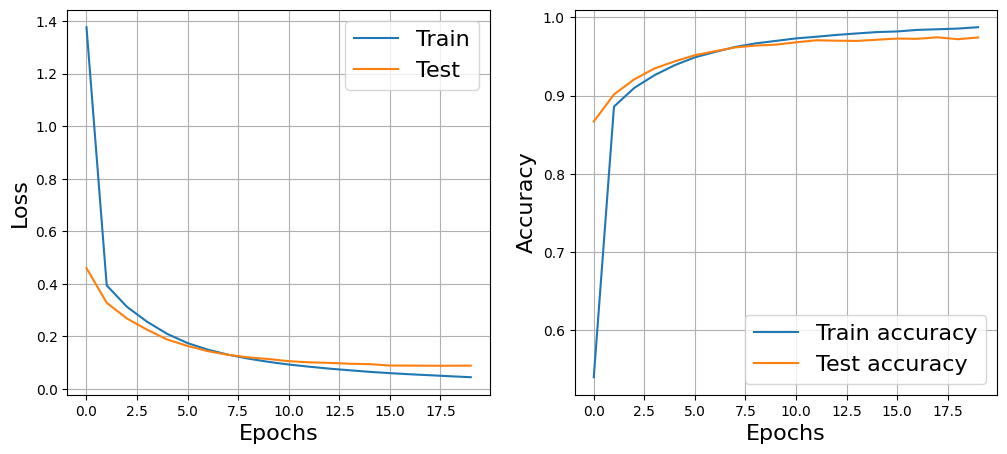

In [33]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

Обучим с аугментацией-поворотом:

Epoch 19... (Train/Test) NLL: 0.078/0.067	Accuracy: 0.976/0.978

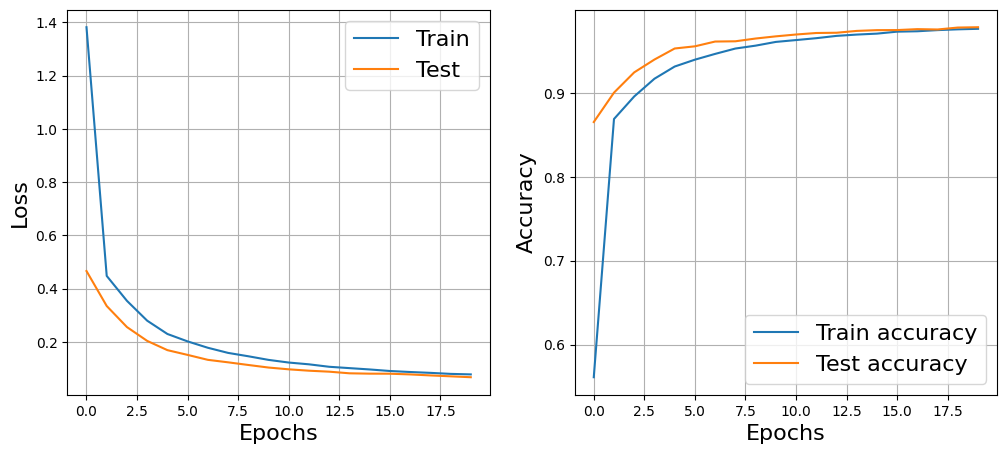

In [13]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01, aug_types=['rotate'])

Обучим с аугментацией-сдвигом:

Epoch 19... (Train/Test) NLL: 0.121/0.077	Accuracy: 0.963/0.974

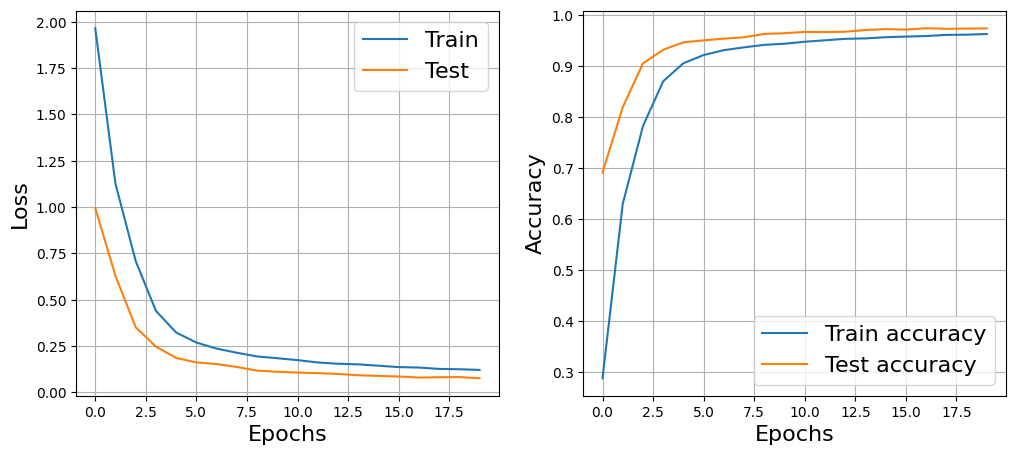

In [14]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01, aug_types=['shift'])

Обучим с аугментацией-шумами:

Epoch 19... (Train/Test) NLL: 0.098/0.218	Accuracy: 0.971/0.947

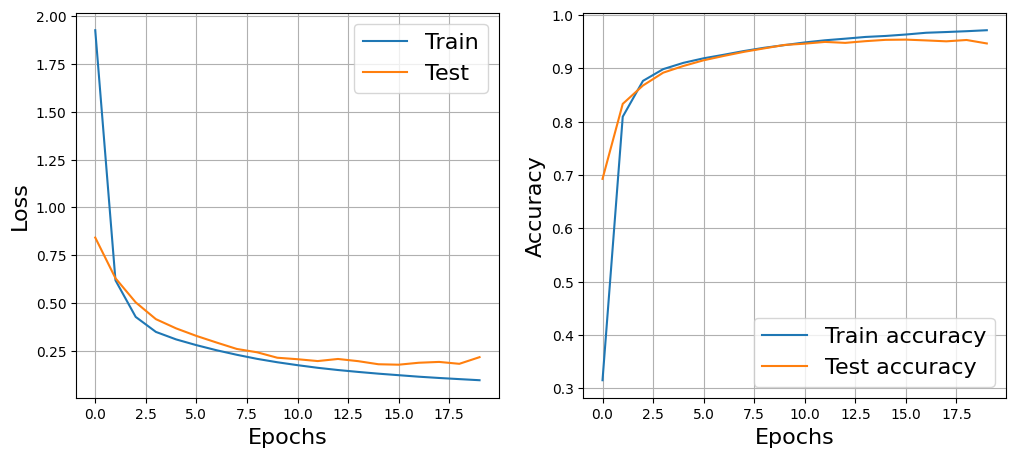

In [7]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01, aug_types=['noise'])

Обучим со всеми видами аугментаций:

Epoch 9... (Train/Test) NLL: 0.211/0.454	Accuracy: 0.937/0.898

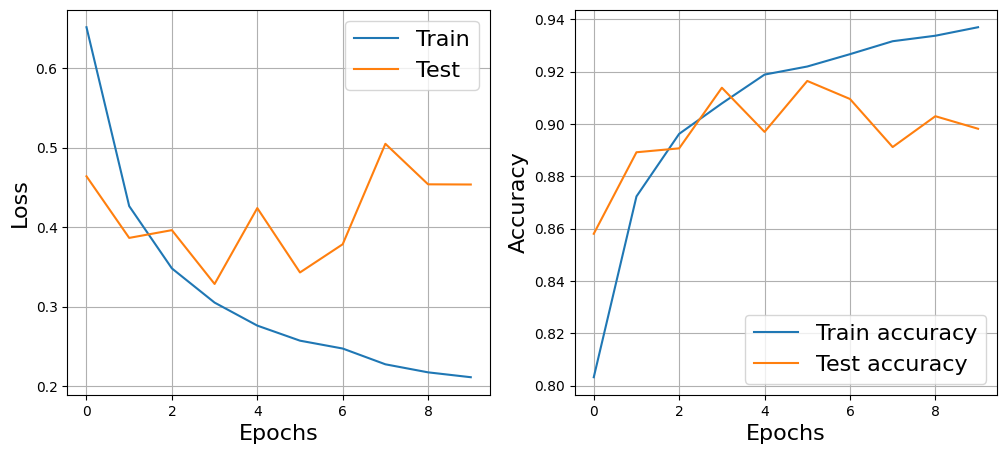

In [8]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01, aug_types=['rotate', 'shift', 'noise'])

Обучим со случайным выбором одной из трёх аугментаций:

Epoch 19... (Train/Test) NLL: 0.116/0.060	Accuracy: 0.966/0.980

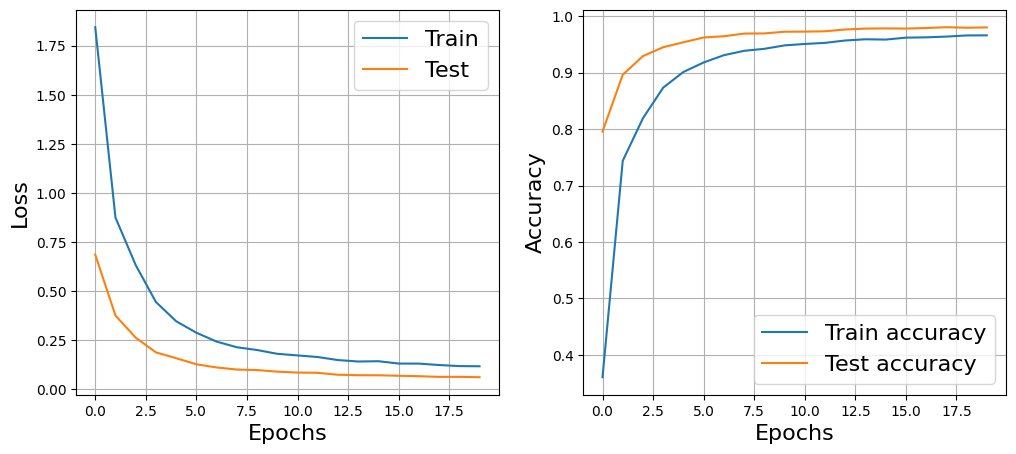

In [15]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01, aug_types=['rotate', 'shift', 'noise'], random_choice=True)

<h4><b>Вывод</b></h4><p>Для данного случая исходная модель была уже обучена очень хорошо, поэтому существенного улучшения метрик с появлянием аугментаций не наблюдается - результаты обучения исходной модели сравнимы с результатами обучения моделей с аугментациями.</p><p>В итоге, лучшую метрику на тесте, чем исходная модель дали модель с вращением и модель со случайным выбором аугментации. Модель со сдвигами показала примерно такую же метрику на тесте, как исходная, модель с шумами - стала хуже.</p>